In [1]:
import numpy as np
from scipy.optimize import curve_fit
from utils import sample_observed_data_berkson, sample_observed_data_classical

In [24]:
confidence_level = 0.90
num_realizations = 100
seed = 112
#folder_path = '/dcs/pg23/u1604520/mem/results/exponential_classical_unifstart/new/misp/'
folder_path = '/dcs/pg23/u1604520/mem/results/exponential_classical_unifstart/new/'
# folder_path_simex = folder_path+'simex/exponential_classical_unifstart_misp/'
folder_path_simex = folder_path+'simex/exponential_classical_unifstart/'

In [25]:
scales_nu = [0.000001, 0.5,  1.0, 2.0] 
num_scales = len(scales_nu)
c = 1
n = 200
B = 500
theta_star = np.array([1,2]) 
loc_x = 0
scale_x = 1
scale_eps = 0.5
num_methods = 3

In [26]:
def reg_func(theta,x):
    return (np.exp(theta[0] + theta[1]*x))/(1 + np.exp(theta[0] + theta[1]*x))

In [27]:
def nonlinear_model(x, a, b):
    return (np.exp(a + b*x))/(1 + np.exp(a + b*x)) 

In [28]:
mses = np.zeros((num_scales, num_realizations, num_methods, len(theta_star)))
stds = np.zeros((num_scales, num_realizations, num_methods, len(theta_star)))
counts = np.zeros((num_scales, len(theta_star)))
coverage_probabilities = np.zeros((num_scales, len(theta_star)))
for j, scale_nu in enumerate(scales_nu):
    seed1 = 12
    seed2 = 112
    seed = 12
    for r in range(num_realizations):
        seed2 += 1
        seed1 += 1
        seed += 1
        boot_sample = np.loadtxt(folder_path+f'sample_scale_nu{scale_nu}_c{c}_n{n}_B{B}_seed1{seed1}_seed2{seed2}.txt')
        if scale_nu == 1.0:
            simex_sample = np.loadtxt(folder_path_simex+f'simex_scale_nu{1}_seed{seed}.txt')
        elif scale_nu == 2.0:
            simex_sample = np.loadtxt(folder_path_simex+f'simex_scale_nu{2}_seed{seed}.txt')
        else:
            simex_sample = np.loadtxt(folder_path_simex+f'simex_scale_nu{scale_nu}_seed{seed}.txt')
        data, x = sample_observed_data_classical(reg_func, int(n), loc_x, scale_x, scale_nu, scale_eps, theta_star, seed1)#np.loadtxt(folder_path+f'data_scale_nu{scale_nu}_c{c}_n{n}_B{B}_seed{seed}.txt')
        mean_boot_sample = boot_sample.mean(axis=0)
        #mean_simex_sample = simex_sample.mean(axis=0)
        initial_guess = np.random.uniform(low=-1, high=4, size=(2,)) #[0, 4]  # Initial parameter guess
        ls_estimator, _ = curve_fit(nonlinear_model, data[:,0], data[:,1], p0=initial_guess)
        mses[j, r, 0, :] = np.asarray((mean_boot_sample - theta_star)**2)
        mses[j, r, 1, :] = np.asarray((simex_sample - theta_star)**2)
        mses[j, r, 2, :] = np.asarray((ls_estimator - theta_star)**2)

        # Credible interval 
        for i in range(len(theta_star)):
            count = 0
            lower_bound = np.percentile(boot_sample[:, i], (1 - confidence_level) / 2 * 100)
            upper_bound = np.percentile(boot_sample[:, i], (1 + confidence_level) / 2 * 100)
            if lower_bound <= theta_star[i] <= upper_bound:
                count += 1
            counts[j, i] += count
            
    # Calculate the coverage probability
    coverage_probabilities[j, :] = counts[j, :] / num_realizations
    mses_over_runs = np.mean(mses, axis=1)
    stds_mses_over_runs = np.std(mses, axis=1)
        
    print(f"Coverage Probability for theta_1 for ME std {scale_nu}: {coverage_probabilities[j, 0] * 100}%")
    print(f"Coverage Probability for theta_2 for ME std {scale_nu}: {coverage_probabilities[j, 1] * 100}%")
    #print(f"Coverage Probability for theta_3 for ME std {scale_nu}: {coverage_probabilities[2] * 100}%")
    print(f"Mean Squared error for Robust-MEM: {mses_over_runs[j, 0, :]}")
    print(f"Mean Squared error for SIMEX: {mses_over_runs[j, 1, :]}")
    print(f"Mean Squared error for Least Squares: {mses_over_runs[j, 2, :]}")
    print(f"Std - Mean Squared error for Robust-MEM: {stds_mses_over_runs[j, 0, :]}")
    print(f"Std - Mean Squared error for SIMEX: {stds_mses_over_runs[j, 1, :]}")
    print(f"Std - Mean Squared error for Least Squares: {stds_mses_over_runs[j, 2, :]}")

Coverage Probability for theta_1 for ME std 1e-06: 98.0%
Coverage Probability for theta_2 for ME std 1e-06: 100.0%
Mean Squared error for Robust-MEM: [0.09783122 0.05463634]
Mean Squared error for SIMEX: [0.09632831 0.26430582]
Mean Squared error for Least Squares: [0.09632249 0.26427179]
Std - Mean Squared error for Robust-MEM: [0.11533274 0.07221301]
Std - Mean Squared error for SIMEX: [0.17866025 0.55164394]
Std - Mean Squared error for Least Squares: [0.17860876 0.55142929]
Coverage Probability for theta_1 for ME std 0.5: 98.0%
Coverage Probability for theta_2 for ME std 0.5: 100.0%
Mean Squared error for Robust-MEM: [0.11436089 0.06285118]
Mean Squared error for SIMEX: [0.11090373 0.32334805]
Mean Squared error for Least Squares: [0.07703241 0.38494971]
Std - Mean Squared error for Robust-MEM: [0.13037605 0.08576465]
Std - Mean Squared error for SIMEX: [0.20163872 0.66284626]
Std - Mean Squared error for Least Squares: [0.0925875  0.31391509]
Coverage Probability for theta_1 for M

### Make a table

In [29]:
import pandas as pd

Coverage probabilities for Robust MEM

In [30]:
dfs = []
for i, scale_nu in enumerate(scales_nu):
    data_coverage = {'Param': ['$\theta_1$', '$\theta_2$'], 'Coverage prob.': coverage_probabilities[i, :], '$\sigma_\nu$': scale_nu}
    df = pd.DataFrame(data_coverage)
    dfs.append(df)
cov_df = pd.concat(dfs, ignore_index=True)
cov_gb = cov_df.groupby((['Param', '$\sigma_\nu$'])).mean()
pivot_cov = cov_gb.pivot_table(index=['Param'], columns='$\sigma_\nu$', values=['Coverage prob.'])
pivot_cov

Coverage prob.                           
$\sigma_
u$       0.000001 0.500000 1.000000 2.000000
Param                                                
$\theta_1$            0.98     0.98     0.98     0.97
$\theta_2$            1.00     1.00     1.00     1.00

In [31]:
latex_table = pivot_cov.to_latex()
print(latex_table)

\begin{tabular}{lrrrr}
\toprule
 & \multicolumn{4}{r}{Coverage prob.} \\
$\sigma_
u$ & 0.000001 & 0.500000 & 1.000000 & 2.000000 \\
Param &  &  &  &  \\
\midrule
$	heta_1$ & 0.980000 & 0.980000 & 0.980000 & 0.970000 \\
$	heta_2$ & 1.000000 & 1.000000 & 1.000000 & 1.000000 \\
\bottomrule
\end{tabular}



MSE and STD

In [32]:
def create_dataframe(mse_array, std_array, scale_nu, method_name):
    
    data = {'Param': ['$\theta_1$', '$\theta_2$'], 'MSE': mse_array, 'Std': std_array, '$\sigma_\nu$': scale_nu, 'Method': [method_name]*len(mse_array)}
    df = pd.DataFrame(data)
    
    return df

In [33]:
dfs = []
for i, scale_nu in enumerate(scales_nu):
    df = create_dataframe(mses_over_runs[i,0,:], stds_mses_over_runs[i,0,:], scale_nu, 'Robust-MEM (MMD)')
    dfs.append(df)
robustmem_df = pd.concat(dfs, ignore_index=True)

In [34]:
dfs = []
for i, scale_nu in enumerate(scales_nu):
    df = create_dataframe(mses_over_runs[i,1,:], stds_mses_over_runs[i,1,:], scale_nu, 'SIMEX')
    dfs.append(df)
simex_df = pd.concat(dfs, ignore_index=True)

In [35]:
dfs = []
for i, scale_nu in enumerate(scales_nu):
    df = create_dataframe(mses_over_runs[i,2,:], stds_mses_over_runs[i,2,:], scale_nu, 'LS')
    dfs.append(df)
ls_df = pd.concat(dfs, ignore_index=True)

In [36]:
df_all = pd.concat([robustmem_df, simex_df, ls_df])

In [37]:
df_all

,Param,MSE,Std,$\sigma_\nu$,Method
0,$\theta_1$,0.097831,0.115333,0.000001,Robust-MEM (MMD)
1,$\theta_2$,0.054636,0.072213,0.000001,Robust-MEM (MMD)
2,$\theta_1$,0.114361,0.130376,0.500000,Robust-MEM (MMD)
3,$\theta_2$,0.062851,0.085765,0.500000,Robust-MEM (MMD)
4,$\theta_1$,0.158763,0.167841,1.000000,Robust-MEM (MMD)
5,$\theta_2$,0.088572,0.118746,1.000000,Robust-MEM (MMD)
6,$\theta_1$,0.271608,0.250996,2.000000,Robust-MEM (MMD)
7,$\theta_2$,0.158874,0.180557,2.000000,Robust-MEM (MMD)
0,$\theta_1$,0.096328,0.178660,0.000001,SIMEX
1,$\theta_2$,0.264306,0.551644,0.000001,SIMEX


In [38]:
gb = df_all.groupby(['Method', 'Param', '$\sigma_\nu$']).mean()

In [39]:
pivot_df = gb.pivot_table(index=['Method', 'Param'], columns='$\sigma_\nu$', values=['MSE','Std'])

# Flatten the MultiIndex columns
pivot_df.columns = [f'{col[0]}-{col[1]}' for col in pivot_df.columns]

cols = pivot_df.columns.tolist()
mse_cols = [col for col in cols if 'MSE' in col]
std_cols = [col for col in cols if 'Std' in col]
rearranged_cols = [item for pair in zip(mse_cols, std_cols) for item in pair]
pivot_df = pivot_df[rearranged_cols]

# Reset index to make 'method' and 'param' regular columns
pivot_df.reset_index(inplace=True)
pivot_df

,Method,Param,MSE-1e-06,Std-1e-06,MSE-0.5,Std-0.5,MSE-1.0,Std-1.0,MSE-2.0,Std-2.0
0,LS,$\theta_1$,0.096322,0.178609,0.077032,0.092588,0.118297,0.201373,0.138541,0.127237
1,LS,$\theta_2$,0.264272,0.551429,0.384950,0.313915,1.454986,0.490660,2.926160,0.359762
2,Robust-MEM (MMD),$\theta_1$,0.097831,0.115333,0.114361,0.130376,0.158763,0.167841,0.271608,0.250996
3,Robust-MEM (MMD),$\theta_2$,0.054636,0.072213,0.062851,0.085765,0.088572,0.118746,0.158874,0.180557
4,SIMEX,$\theta_1$,0.096328,0.178660,0.110904,0.201639,0.261294,1.562083,0.129625,0.126831
5,SIMEX,$\theta_2$,0.264306,0.551644,0.323348,0.662846,0.747823,1.019098,2.244498,0.575986


In [40]:
pivot_df = pivot_df.groupby(['Method', 'Param']).mean()
pivot_df

MSE-1e-06  Std-1e-06   MSE-0.5   Std-0.5  \
Method           Param                                                  
LS               $\theta_1$   0.096322   0.178609  0.077032  0.092588   
                 $\theta_2$   0.264272   0.551429  0.384950  0.313915   
Robust-MEM (MMD) $\theta_1$   0.097831   0.115333  0.114361  0.130376   
                 $\theta_2$   0.054636   0.072213  0.062851  0.085765   
SIMEX            $\theta_1$   0.096328   0.178660  0.110904  0.201639   
                 $\theta_2$   0.264306   0.551644  0.323348  0.662846   

                              MSE-1.0   Std-1.0   MSE-2.0   Std-2.0  
Method           Param                                               
LS               $\theta_1$  0.118297  0.201373  0.138541  0.127237  
                 $\theta_2$  1.454986  0.490660  2.926160  0.359762  
Robust-MEM (MMD) $\theta_1$  0.158763  0.167841  0.271608  0.250996  
                 $\theta_2$  0.088572  0.118746  0.158874  0.180557  
SIMEX            $\theta_1$  0.261294  1.562083  0.129625  0.126831  
                 $\theta_2$  0.747823  1.019098  2.244498  0.575986

In [41]:
new_df = pivot_df.copy(deep=True)
nus = [1e-06, 0.5, 1.0, 2.0]
# Iterate over columns
for i, nu in enumerate(nus):  # Assuming you have two pairs a_i and b_i
    # Extract corresponding pairs
    a_col = f'MSE-{nu}'
    b_col = f'Std-{nu}'
    # Concatenate values for the title
    new_df[f'$\sigma_\nu = {nu}$'] = pivot_df[a_col].round(3).astype(str) + ' ' + '(' + pivot_df[b_col].round(3).astype(str) + ')'
    new_df = new_df.drop(a_col, axis=1)
    new_df = new_df.drop(b_col, axis=1) 
    

new_df

$\sigma_\nu = 1e-06$ $\sigma_\nu = 0.5$  \
Method           Param                                                
LS               $\theta_1$        0.096 (0.179)      0.077 (0.093)   
                 $\theta_2$        0.264 (0.551)      0.385 (0.314)   
Robust-MEM (MMD) $\theta_1$        0.098 (0.115)       0.114 (0.13)   
                 $\theta_2$        0.055 (0.072)      0.063 (0.086)   
SIMEX            $\theta_1$        0.096 (0.179)      0.111 (0.202)   
                 $\theta_2$        0.264 (0.552)      0.323 (0.663)   

                            $\sigma_\nu = 1.0$ $\sigma_\nu = 2.0$  
Method           Param                                             
LS               $\theta_1$      0.118 (0.201)      0.139 (0.127)  
                 $\theta_2$      1.455 (0.491)       2.926 (0.36)  
Robust-MEM (MMD) $\theta_1$      0.159 (0.168)      0.272 (0.251)  
                 $\theta_2$      0.089 (0.119)      0.159 (0.181)  
SIMEX            $\theta_1$      0.261 (1.562)       0.13 (0.127)  
                 $\theta_2$      0.748 (1.019)      2.244 (0.576)

In [42]:
latex_table =new_df.to_latex()
print(latex_table)

\begin{tabular}{llllll}
\toprule
 &  & $\sigma_
u = 1e-06$ & $\sigma_
u = 0.5$ & $\sigma_
u = 1.0$ & $\sigma_
u = 2.0$ \\
Method & Param &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{LS} & $	heta_1$ & 0.096 (0.179) & 0.077 (0.093) & 0.118 (0.201) & 0.139 (0.127) \\
 & $	heta_2$ & 0.264 (0.551) & 0.385 (0.314) & 1.455 (0.491) & 2.926 (0.36) \\
\cline{1-6}
\multirow[t]{2}{*}{Robust-MEM (MMD)} & $	heta_1$ & 0.098 (0.115) & 0.114 (0.13) & 0.159 (0.168) & 0.272 (0.251) \\
 & $	heta_2$ & 0.055 (0.072) & 0.063 (0.086) & 0.089 (0.119) & 0.159 (0.181) \\
\cline{1-6}
\multirow[t]{2}{*}{SIMEX} & $	heta_1$ & 0.096 (0.179) & 0.111 (0.202) & 0.261 (1.562) & 0.13 (0.127) \\
 & $	heta_2$ & 0.264 (0.552) & 0.323 (0.663) & 0.748 (1.019) & 2.244 (0.576) \\
\cline{1-6}
\bottomrule
\end{tabular}



Plot

In [43]:
def lighten_color(color, amount=0.5):
    """
    From: https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [44]:
pip install seaborn

/dcs/pg23/u1604520/.conda/envs/mem-env/lib/python3.9/pty.py:85: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


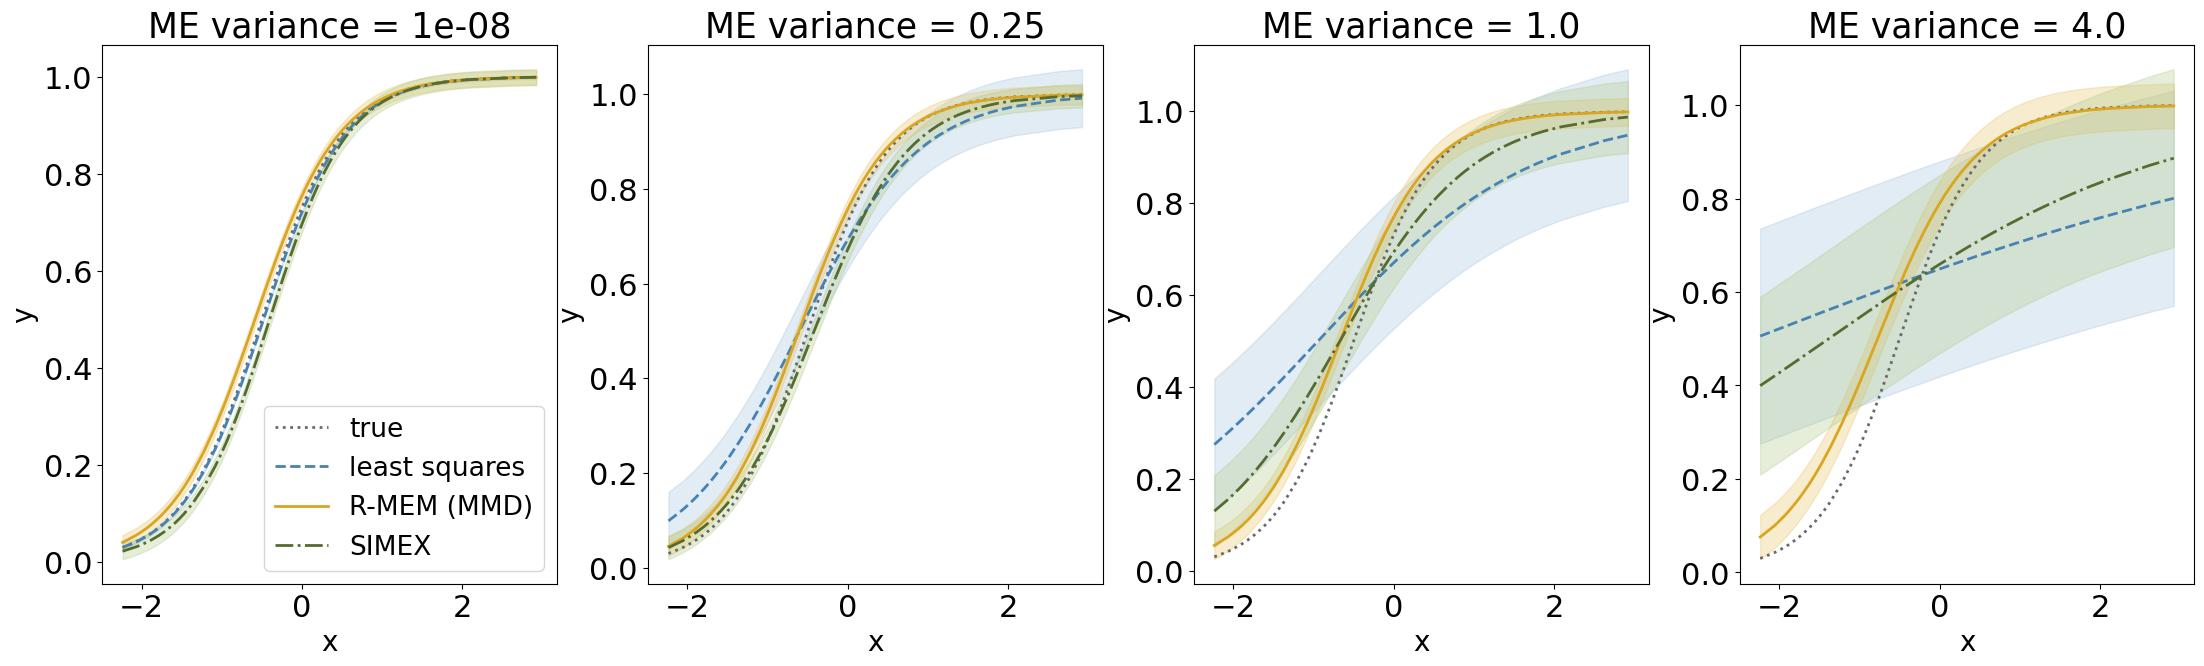

In [45]:
import matplotlib.pyplot as plt
num_methods = 3
num_realizations = 10
num_scales = len(scales_nu)
fig, ax_array = plt.subplots(1, num_scales, figsize=(27,7))
credible_interval = 0.90
n = 200
regs = np.zeros((num_realizations, num_methods, n))
lower_bounds = np.zeros((num_methods, n))
upper_bounds = np.zeros((num_methods, n))
std_error = np.zeros(num_methods)
means = np.zeros((num_methods, n))
for ax, j in zip(ax_array.flatten(), range(0, num_scales)):
    scale_nu = scales_nu[j]
    seed1 = 12
    seed2 = 112
    thetas_over_run = np.zeros((len(theta_star), num_methods, num_realizations))
    for r in range(num_realizations):
        seed1 += 1
        seed2 += 1
        boot_sample = np.loadtxt(folder_path+f'sample_scale_nu{scale_nu}_c{c}_n{n}_B{B}_seed1{seed1}_seed2{seed2}.txt')
        if scale_nu == 1.0:
            simex_sample = np.loadtxt(folder_path_simex+f'simex_scale_nu{1}_seed{seed1}.txt')
        elif scale_nu == 2.0:
            simex_sample = np.loadtxt(folder_path_simex+f'simex_scale_nu{2}_seed{seed1}.txt')
        else:
            simex_sample = np.loadtxt(folder_path_simex+f'simex_scale_nu{scale_nu}_seed{seed}.txt')
        data, xis_star = sample_observed_data_classical(reg_func, int(n), loc_x, scale_x, scale_nu, scale_eps, theta_star, seed1)#np.loadtxt(folder_path+f'data_scale_nu{scale_nu}_c{c}_n{n}_B{B}_seed{seed}.txt')
        mean_boot_sample = boot_sample.mean(axis=0)
        initial_guess = np.random.uniform(low=-1, high=4, size=(2,)) #[0, 4]  # Initial parameter guess
        ls_estimator, _ = curve_fit(nonlinear_model, data[:,0], data[:,1], p0=initial_guess)
        thetas_over_run[:, 0, r] = mean_boot_sample
        thetas_over_run[:, 1, r] = simex_sample
        thetas_over_run[:, 2, r] = ls_estimator
        # xis_star_sorted = np.sort(xis_star)
        # regs[r,0,:] = reg_func(thetas_over_run[:,0,r], xis_star_sorted)
        # regs[r,1,:] = reg_func(thetas_over_run[:,1,r], xis_star_sorted)
        # regs[r,2,:] = reg_func(thetas_over_run[:,2,r], xis_star_sorted)
        
    # test data
    data, xis_star = sample_observed_data_classical(reg_func, int(n), loc_x, scale_x, scale_nu, scale_eps, theta_star, 300)
    xis_star_sorted = np.sort(xis_star)
    Y_real = reg_func(theta_star, xis_star_sorted)
    means[0, :] = reg_func(thetas_over_run[:,0,:].mean(axis=1), xis_star_sorted)
    residuals = np.array(Y_real) - means[0, :]
    std_error[0] = np.std(residuals, axis=0)
    lower_bounds[0, :] = reg_func(thetas_over_run[:,0,:].mean(axis=1) - thetas_over_run[:,0,:].std(axis=1), xis_star_sorted)
    upper_bounds[0, :] = reg_func(thetas_over_run[:,0,:].mean(axis=1) + thetas_over_run[:,0,:].std(axis=1), xis_star_sorted)

    means[1, :] = reg_func(thetas_over_run[:,1,:].mean(axis=1), xis_star_sorted)
    residuals = np.array(Y_real) - means[1, :]
    std_error[1] = np.std(residuals, axis=0)
    lower_bounds[1, :] = reg_func(thetas_over_run[:,1,:].mean(axis=1) - thetas_over_run[:,1,:].std(axis=1), xis_star_sorted)
    upper_bounds[1, :] = reg_func(thetas_over_run[:,1,:].mean(axis=1) + thetas_over_run[:,1,:].std(axis=1), xis_star_sorted)

    means[2, :] = reg_func(thetas_over_run[:,2,:].mean(axis=1), xis_star_sorted)
    residuals = np.array(Y_real) - means[2, :]
    std_error[2] = np.std(residuals, axis=0)
    lower_bounds[2, :] = reg_func(thetas_over_run[:,2,:].mean(axis=1) - thetas_over_run[:,2,:].std(axis=1), xis_star_sorted)
    upper_bounds[2, :] = reg_func(thetas_over_run[:,2,:].mean(axis=1) + thetas_over_run[:,2,:].std(axis=1), xis_star_sorted)
    
    
    ax.plot(xis_star_sorted, Y_real, linestyle='dotted', label='true', color='dimgrey', lw=2)
    
    ax.plot(xis_star_sorted, means[2,:], linestyle='dashed', label='least squares', color='#4682B4', lw=2)
    #ax.fill_between(xis_star_sorted, lower_bounds[2, :], upper_bounds[2, :], color=lighten_color('#4682B4'), alpha=0.3)
    ax.fill_between(xis_star_sorted, means[2, :] - std_error[2], means[2, :] + std_error[2], color=lighten_color('#4682B4'), alpha=0.3)
    
    ax.plot(xis_star_sorted, means[0, :], linestyle='solid', label='R-MEM (MMD)', color='goldenrod',lw=2)
    #ax.fill_between(xis_star_sorted, lower_bounds[0, :], upper_bounds[0, :], color=lighten_color('goldenrod', 0.7), alpha=0.3)
    ax.fill_between(xis_star_sorted, means[0, :] - std_error[0], means[0, :] + std_error[0], color=lighten_color('goldenrod', 0.7), alpha=0.3)

    ax.plot(xis_star_sorted, means[1, :], linestyle='dashdot', label='SIMEX',color='#556B2F', lw=2)
    #ax.fill_between(xis_star_sorted, lower_bounds[1, :], upper_bounds[1, :], color=lighten_color('#556B2F'), alpha=0.3)
    ax.fill_between(xis_star_sorted, means[1, :] - std_error[1], means[1, :] + std_error[1], color=lighten_color('#556B2F'), alpha=0.3)
    
    ax.yaxis.grid(False)
    ax.xaxis.grid(False)
    ax.patch.set_facecolor('white')
    if j == 0:
        ax.set_title(f'ME variance = 1e-08', fontsize=25)
    elif j == 1 or j == 3:
        ax.set_title(f'ME variance = {scale_nu**2}', fontsize=25)
    elif j == 2:
        ax.set_title(f'ME variance = {scale_nu**2}', fontsize=25)

    ax.set_xlabel('x',fontsize=20)
    ax.set_ylabel('y',fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=22)
    ax.tick_params(axis='both', which='minor', labelsize=22)
    if j == 0:
        ax.legend(fontsize=19)